## Advanced Seminar for Recognition System
##### Masashi Nakayama - Fall Semester 2025/26
### Jan Niklas Kappey (ID: 2568017)


**Create a linearly indistinguishable multi-class classification
system using a multi-layer perceptron. Please present your
findings, including any ingenuity you have used.**

In [1]:
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split

# Download latest version
path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")

print("Path to dataset files:", path)
print(os.listdir(path))

2026-01-21 07:50:20.362877: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-21 07:50:20.633131: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI AVX512_BF16, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Path to dataset files: /home/nikla/.cache/kagglehub/datasets/drgfreeman/rockpaperscissors/versions/2
['scissors', 'rock', 'README_rpc-cv-images.txt', 'rps-cv-images', 'paper']


In [2]:
import tensorflow as tf
print("GPUs:", tf.config.list_physical_devices("GPU"))

GPUs: []


In [3]:
labels = ['paper','scissors','rock']

In [4]:
data_augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [5]:
from keras.saving import register_keras_serializable

@register_keras_serializable()
class CNN(Model):
    def __init__(self, hidden_dim=512, output_dim=3):
        super().__init__()
        self.l1 = Conv2D(64, (3, 3), activation='relu')
        self.l2 = MaxPooling2D((2, 2))
        self.l3 = Conv2D(32, (3, 3), activation='relu')
        self.l4 = MaxPooling2D((2, 2))
        self.l5 = Flatten()
        self.l6 = Dense(hidden_dim, activation='relu')
        self.l7 = Dense(output_dim, activation='softmax')

        # Define the layer sequence you intended to iterate through
        self.ls = [self.l1, self.l2, self.l3, self.l4, self.l5, self.l6, self.l7]

    def call(self, x, training=False):
        if training:
            x = data_augment(x)
        for layer in self.ls:
            x = layer(x)
        return x


In [6]:
def input_target_split(root_dir, labels, image_size=(128, 128)):
    dataset = []
    for class_id, label in enumerate(labels):
        folder = os.path.join(root_dir, label)
        if not os.path.isdir(folder):
            raise FileNotFoundError(
                f"Couldn't find folder: {folder}\n"
                f"Check your dataset path. Top-level contents: {os.listdir(root_dir)}"
            )

        for fname in os.listdir(folder):
            fpath = os.path.join(folder, fname)
            img = load_img(fpath, target_size=image_size)
            img = img_to_array(img).astype("float32") / 255.0
            dataset.append((img, class_id))

    X, y = zip(*dataset)
    return np.array(X, dtype="float32"), np.array(y, dtype="int32")

In [7]:
X, y = input_target_split(path,labels)

In [8]:
# train / val / test split
x_train, x_tmp, t_train, t_tmp = train_test_split(
    X, y, test_size=0.3, random_state=1234, stratify=y)

x_val, x_test, t_val, t_test = train_test_split(
    x_tmp, t_tmp, test_size=0.67, random_state=1234, stratify=t_tmp)


In [9]:
n = len(labels)
model = CNN(hidden_dim=12, output_dim=n)

# IMPORTANT: use sparse loss/acc since labels are integers
criterion = losses.SparseCategoricalCrossentropy()
optimizer = optimizers.SGD(learning_rate=0.01)

train_loss = metrics.Mean(name="train_loss")
train_acc = metrics.SparseCategoricalAccuracy(name="train_acc")
val_acc = metrics.SparseCategoricalAccuracy(name="val_acc")

In [10]:
def compute_loss(t, y):
    return criterion(t, y)

@tf.function
def train_step(x, t):
    with tf.GradientTape() as tape:
        preds = model(x, training=True)
        loss = criterion(t, preds)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss.update_state(loss)
    train_acc.update_state(t, preds)
    return loss

@tf.function
def test_step(x, t):
    preds = model(x, training=False)
    loss = criterion(t, preds)
    test_loss.update_state(loss)
    test_acc.update_state(t, preds)
    return loss
    
@tf.function
def val_step(x, t):
    preds = model(x, training=False)
    val_acc.update_state(t, preds)

In [11]:
epochs = 100
batch_size = 16
n_batches = x_train.shape[0] // batch_size

loss_history = []
acc_history = []

for epoch in range(epochs):
    # reset metrics EACH epoch (otherwise they accumulate across epochs)
    train_loss.reset_state()
    train_acc.reset_state()

    x_, t_ = shuffle(x_train, t_train, random_state=epoch)

    for batch in range(n_batches):
        start = batch * batch_size
        end = start + batch_size
        train_step(x_[start:end], t_[start:end])
        
    loss_history.append(train_loss.result().numpy())
    acc_history.append(train_acc.result().numpy())

    val_acc.reset_state()
    val_step(x_val, t_val)

    print(
    f"epoch: {epoch+1}, "
    f"loss: {train_loss.result():.3f}, "
    f"train_acc: {train_acc.result():.3f}, "
    f"val_acc: {val_acc.result():.3f}"
)

epoch: 1, loss: 1.097, train_acc: 0.357, val_acc: 0.338
epoch: 2, loss: 1.080, train_acc: 0.433, val_acc: 0.361
epoch: 3, loss: 1.053, train_acc: 0.518, val_acc: 0.657
epoch: 4, loss: 1.018, train_acc: 0.590, val_acc: 0.722
epoch: 5, loss: 0.984, train_acc: 0.615, val_acc: 0.727
epoch: 6, loss: 0.945, train_acc: 0.628, val_acc: 0.690
epoch: 7, loss: 0.868, train_acc: 0.689, val_acc: 0.773
epoch: 8, loss: 0.817, train_acc: 0.708, val_acc: 0.736
epoch: 9, loss: 0.760, train_acc: 0.729, val_acc: 0.861
epoch: 10, loss: 0.714, train_acc: 0.739, val_acc: 0.815
epoch: 11, loss: 0.665, train_acc: 0.761, val_acc: 0.787
epoch: 12, loss: 0.623, train_acc: 0.778, val_acc: 0.852
epoch: 13, loss: 0.592, train_acc: 0.789, val_acc: 0.870
epoch: 14, loss: 0.568, train_acc: 0.799, val_acc: 0.870
epoch: 15, loss: 0.502, train_acc: 0.824, val_acc: 0.884
epoch: 16, loss: 0.503, train_acc: 0.811, val_acc: 0.870
epoch: 17, loss: 0.502, train_acc: 0.824, val_acc: 0.898
epoch: 18, loss: 0.455, train_acc: 0.826

In [12]:
test_loss = metrics.Mean(name="test_loss")
test_acc = metrics.SparseCategoricalAccuracy(name="test_acc")

test_loss.reset_state()
test_acc.reset_state()
val_step(x_test, t_test)

print(f"test_loss: {test_loss.result():.3f}, test_acc: {test_acc.result():.3f}")

test_loss: 0.000, test_acc: 0.000


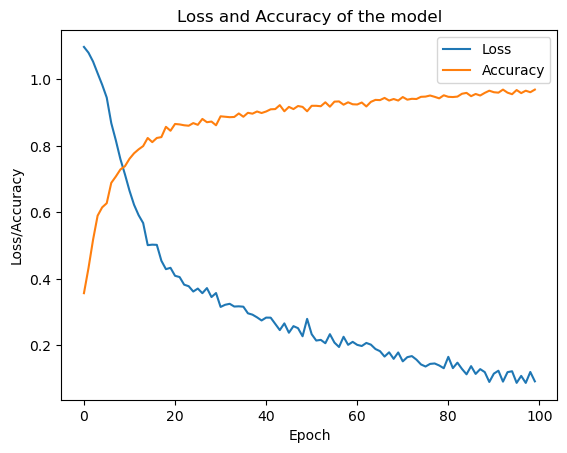

In [13]:
plt.figure()  
plt.plot(loss_history)
plt.plot(acc_history)
plt.title('Loss and Accuracy of the model')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend(['Loss', 'Accuracy'])
plt.show()


In [14]:
from sklearn.metrics import confusion_matrix, classification_report

preds = model(x_test, training=False).numpy().argmax(axis=1)

print("Confusion Matrix:")
print(confusion_matrix(t_test, preds))

print("\nClassification Report:")
print(classification_report(t_test, preds, target_names=labels))

Confusion Matrix:
[[141   2   1]
 [  6 145   0]
 [  2   1 143]]

Classification Report:
              precision    recall  f1-score   support

       paper       0.95      0.98      0.96       144
    scissors       0.98      0.96      0.97       151
        rock       0.99      0.98      0.99       146

    accuracy                           0.97       441
   macro avg       0.97      0.97      0.97       441
weighted avg       0.97      0.97      0.97       441



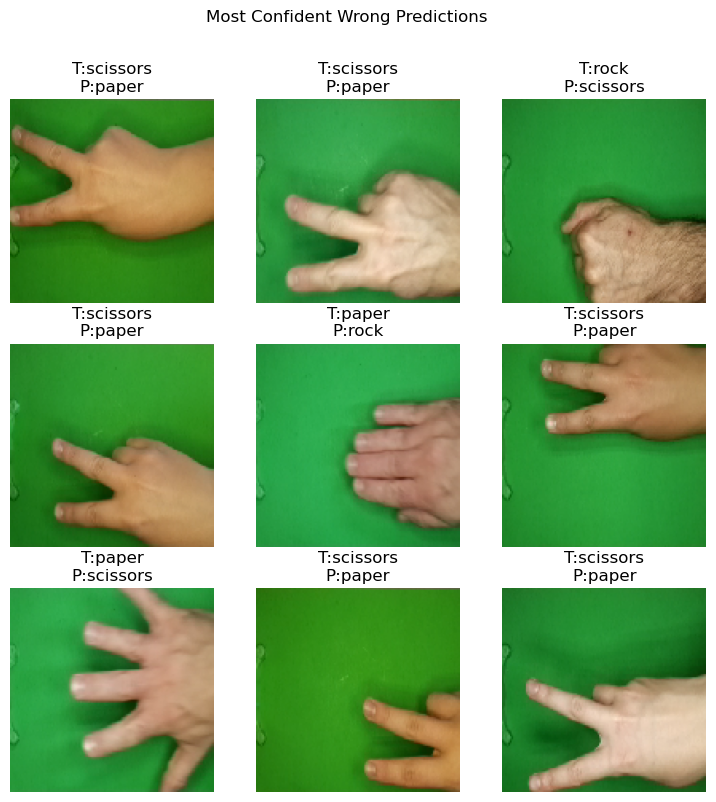

In [15]:
probs = model(x_test, training=False).numpy()
conf = probs[np.arange(len(probs)), preds]
wrong = np.where(preds != t_test)[0]

top_wrong = wrong[np.argsort(-conf[wrong])[:9]]

plt.figure(figsize=(9,9))
for i, idx in enumerate(top_wrong):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[idx])
    plt.title(f"T:{labels[t_test[idx]]}\nP:{labels[preds[idx]]}")
    plt.axis("off")
plt.suptitle("Most Confident Wrong Predictions")
plt.show()

In [16]:
# Download latest version
path2 = kagglehub.dataset_download("glushko/rock-paper-scissors-dataset")


# Simple approach: ignore boxes, just resize whole images
X2, y2 = input_target_split(path2 + "/test", labels)

# small subset to keep it fair
X2, y2 = X2[:300], y2[:300]

preds2 = model(X2, training=False).numpy().argmax(axis=1)

print("Cross-dataset accuracy:",
      np.mean(preds2 == y2))

Cross-dataset accuracy: 0.4033333333333333


In [1]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

# ---------------------------
# 1) Make sure you have preds
# ---------------------------
# preds = model(x_test, training=False).numpy().argmax(axis=1)

# If your ground truth is one-hot, convert to class ids
t_true = np.argmax(t_test, axis=1) if getattr(t_test, "ndim", 1) > 1 else np.asarray(t_test)

# Labels list like: labels = ["cat", "dog", ...]
labels = list(labels)

# ---------------------------
# 2) Output directory
# ---------------------------
OUT_DIR = "eval_figures"
os.makedirs(OUT_DIR, exist_ok=True)

def savefig(path, dpi=200):
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.close()

# ---------------------------
# 3) Confusion matrices
# ---------------------------
cm = confusion_matrix(t_true, preds)
cm_norm = confusion_matrix(t_true, preds, normalize="true")

# Raw confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, colorbar=True, values_format="d")
ax.set_title("Confusion Matrix (Counts)")
savefig(os.path.join(OUT_DIR, "confusion_matrix_counts.png"))

# Normalized confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, colorbar=True, values_format=".2f")
ax.set_title("Confusion Matrix (Normalized by True Class)")
savefig(os.path.join(OUT_DIR, "confusion_matrix_normalized.png"))

# ---------------------------
# 4) Classification report (text) + bar charts
# ---------------------------
report = classification_report(t_true, preds, target_names=labels, digits=4)
print("Classification Report:\n", report)

with open(os.path.join(OUT_DIR, "classification_report.txt"), "w") as f:
    f.write(report)

prec, rec, f1, support = precision_recall_fscore_support(t_true, preds, labels=np.arange(len(labels)), zero_division=0)

x = np.arange(len(labels))

# Precision/Recall/F1 bar chart
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - 0.25, prec, width=0.25, label="Precision")
ax.bar(x,         rec,  width=0.25, label="Recall")
ax.bar(x + 0.25,  f1,   width=0.25, label="F1")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylim(0, 1.0)
ax.set_title("Per-class Precision / Recall / F1")
ax.legend()
savefig(os.path.join(OUT_DIR, "per_class_prf.png"))

# Support bar chart
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(x, support)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_title("Support (Samples per Class)")
savefig(os.path.join(OUT_DIR, "per_class_support.png"))

# ---------------------------
# 5) Optional: show most confused pairs
# ---------------------------
cm_offdiag = cm.copy()
np.fill_diagonal(cm_offdiag, 0)
pairs = np.dstack(np.unravel_index(np.argsort(cm_offdiag.ravel())[::-1], cm_offdiag.shape))[0]

top_k = 10
print("\nTop confused class pairs (true -> predicted):")
count = 0
for i, j in pairs:
    if cm_offdiag[i, j] == 0:
        break
    print(f"  {labels[i]} -> {labels[j]} : {cm_offdiag[i, j]}")
    count += 1
    if count >= top_k:
        break

# ---------------------------
# 6) Optional: gallery of misclassified examples (image data)
# ---------------------------
# If x_test contains images and you want a grid of mistakes, uncomment + adjust:
# - assumes x_test is (N, H, W, C) or (N, H, W)
# - if values are normalized (0..1), imshow works; if standardized, you may need to unnormalize.

# def plot_mistakes(x, y_true, y_pred, labels, n=16, out_path=None):
#     idx = np.where(y_true != y_pred)[0]
#     if len(idx) == 0:
#         print("No misclassifications to plot.")
#         return
#     sel = idx[:n]
#     cols = 4
#     rows = int(np.ceil(len(sel) / cols))
#     fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
#     axes = np.array(axes).reshape(-1)
#     for k, ax in enumerate(axes):
#         if k >= len(sel):
#             ax.axis("off")
#             continue
#         i = sel[k]
#         img = x[i]
#         ax.imshow(img.squeeze(), cmap="gray" if img.ndim == 2 or (img.ndim == 3 and img.shape[-1] == 1) else None)
#         ax.set_title(f"T: {labels[y_true[i]]}\nP: {labels[y_pred[i]]}")
#         ax.axis("off")
#     plt.suptitle("Misclassified Examples", y=1.02)
#     if out_path:
#         savefig(out_path)
#     else:
#         plt.show()
#
# plot_mistakes(x_test, t_true, preds, labels, n=16, out_path=os.path.join(OUT_DIR, "mistakes_grid.png"))

print(f"\nSaved figures + report to: {os.path.abspath(OUT_DIR)}")


NameError: name 't_test' is not defined